In [1]:
! jt -t grade3 -nf opensans

/bin/sh: jt: command not found


<h1><center>1. Load Data</center></h1>



In [1]:
import os
import warnings
import pandas as pd

warnings.filterwarnings(action='ignore', message='numpy.dtype size changed')
warnings.filterwarnings(action='ignore', message='compiletime version 3.5 of module')

if not 'workbookDir' in globals():
    workbookDir = os.getcwd()
os.chdir(os.path.split(workbookDir)[0])

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from synthesized.testing.evaluation import Evaluation
evaluation = Evaluation(config_path='configs/evaluation/dataset_evaluation.json', name='transactions') # use this line if you want to run this notbook manually
#evaluation = Evaluation()


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Copyright (C) Synthesized Ltd. - All Rights Reserved
License key: EE6B-6720-67A2-32F3-3139-2DF3-5D2D-B5F3
Expires at: 2019-06-30 00:00:00


In [3]:
data = pd.read_csv(evaluation.config['data'])
data = data.drop(evaluation.config['ignore_columns'], axis=1)
data.dropna(inplace=True)
data.head(5)

,account_id,date,type,amount
0,2378,1993-01-01,1,700.0
1,2378,1993-01-22,1,7268.0
2,2378,1993-01-23,1,14440.0
3,2378,1993-01-24,1,49752.0
4,2378,1993-01-26,1,21899.0






<h1><center>2. Train model and generate synthetic data</center></h1>

In [4]:
from sklearn.model_selection import train_test_split
import synthesized.core as core

In [5]:
train, test = train_test_split(data, test_size=0.2, random_state=0)

In [6]:
def train_and_synthesize(synthesizer_class=evaluation.config["synthesizer_class"]):
    assert synthesizer_class in {"BasicSynthesizer", "SeriesSynthesizer"}
    synthesizer_constructor = getattr(core, synthesizer_class)
    with synthesizer_constructor(data=data, **evaluation.config['params']) as synthesizer:
        synthesizer.learn(data=train, num_iterations=evaluation.config['num_iterations'], verbose=0)
        if synthesizer_class == "BasicSynthesizer":
            synthesized_data = synthesizer.synthesize(n=len(test))
        else:
            series_lengths = data.groupby(evaluation.config["params"]["identifier_label"]).count().to_numpy().transpose()
            series_lengths = list(series_lengths[0])
            synthesized_data = synthesizer.synthesize(series_lengths=series_lengths)
        return synthesizer, synthesized_data

In [7]:
%%capture
synthesizers_and_results = [train_and_synthesize() for i in range(evaluation.config['num_passes'])]

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.


In [8]:
synthesizer = synthesizers_and_results[0][0]

## Plot losses

In [9]:
synthesizer.get_loss_history().plot(figsize=(15,7))

TypeError: Empty 'DataFrame': no numeric data to plot

## Display aggregated statistics 

In [10]:
from scipy.stats import ks_2samp
import numpy as np
import seaborn as sns

In [11]:
synthesized = [x[1] for x in synthesizers_and_results]

In [23]:
print(synthesized)

[                              date type       amount
0    1995-10-15 03:02:47.159548800    0   854.536404
1    1995-11-07 06:30:45.962006400    0   879.710869
2    1995-11-23 13:07:40.094976000    0   922.144590
3    1995-12-03 03:02:29.009414400    0   973.472493
4    1995-12-08 21:01:02.679139200    0  1026.305018
5    1995-12-12 13:13:52.246819200    0  1076.577770
6    1995-12-15 09:03:11.047680000    0  1120.466214
7    1995-12-18 03:38:47.621616000    0  1155.000116
8    1995-12-20 18:22:21.424108800    0  1184.691204
9    1995-12-23 08:46:08.510505600    0  1210.105777
10   1995-12-26 00:28:42.676464000    0  1231.955979
11   1995-12-28 16:03:23.834649600    0  1250.873743
12   1995-12-31 06:33:36.664300800    0  1267.457946
13   1996-01-02 18:51:41.582275200    0  1282.199105
14   1996-01-05 03:55:52.973529600    0  1295.478140
15   1996-01-07 08:58:30.234547200    0  1307.578300
16   1996-01-09 09:29:54.446265600    0  1318.701276
17   1996-01-11 05:16:39.379612800    0  1328

In [12]:
def plot_avg_distances():
    test_ = synthesizer.preprocess(test.copy())
    result = []
    for i, s in enumerate(synthesized):
        synthesized_ = synthesizer.preprocess(s.copy())
        distances = [ks_2samp(test_[col], synthesized_[col])[0] for col in synthesized_.columns]
        avg_distance = np.mean(distances)
        print('run: {}, AVG distance: {}'.format(i+1, avg_distance))
        result.append({'run': i+1, 'avg_distance': avg_distance})
        evaluation['avg_distance'] = avg_distance
    df = pd.DataFrame.from_records(result)
    df['run'] = df['run'].astype('category')
    g = sns.barplot(y='run', x='avg_distance', data=df)
    g.set_xlim(0.0, 1.0)

run: 1, AVG distance: 0.5190219512195122


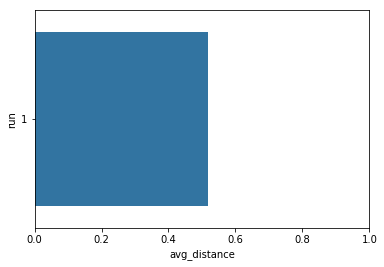

In [13]:
plot_avg_distances()

## Details for the 1st Run 

In [15]:
from synthesized.testing import UtilityTesting
testing = UtilityTesting(synthesizer, train, test, synthesized[0])

In [15]:
testing.show_distribution_distances()

KeyError: 'account_id'

/Users/amandlamabona/PycharmProjects/synthesized/synthesized/testing/utility.py:94: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  concatenated = pd.concat([self.df_test.assign(dataset='orig'), self.df_synth.assign(dataset='synth')])


TypeError: can't multiply sequence by non-int of type 'float'

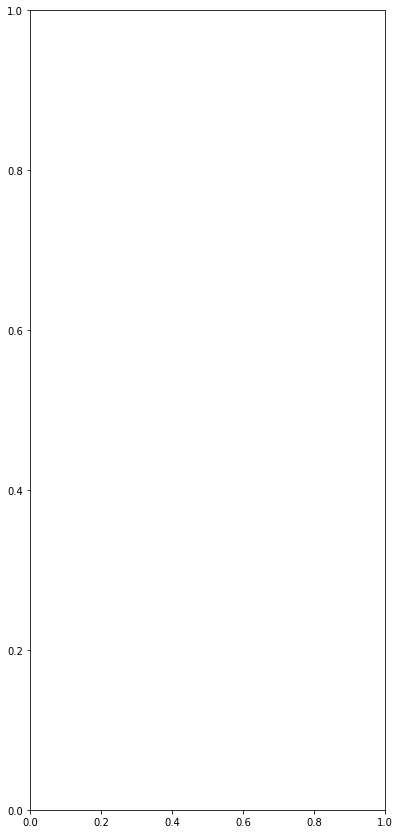

In [16]:
testing.show_distributions(remove_outliers=0.01)

## Display correlations

In [17]:
testing.show_correlation_diffs(threshold=0.2)

KeyError: 'account_id'

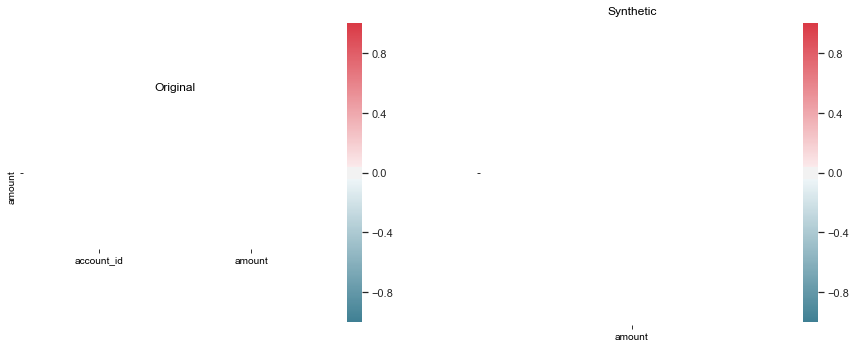

In [18]:
testing.show_corr_matrices()

## Demonstrate the utility for training ML models

In [16]:
try:
    evaluation['utility'] = testing.utility(target=evaluation.config['target'])
except:
    evaluation['utility'] = 0.0

In [18]:
print(evaluation.metrics)

OrderedDict([('utility', [0.0])])
